In [24]:
import sys, os
import numpy
from scipy.interpolate import interp1d
import iris
import iris.plot as iplt
import matplotlib.pyplot as plt

cwd = os.getcwd()
repo_dir = '/'
for directory in cwd.split('/')[1:]:
    repo_dir = os.path.join(repo_dir, directory)
    if directory == 'ocean-analysis':
        break

modules_dir = os.path.join(repo_dir, 'modules')
sys.path.append(modules_dir)
try:
    import general_io as gio
    import convenient_universal as uconv
    import timeseries
except ImportError:
    raise ImportError('Must run this script from anywhere within the ocean-analysis git repo')

In [21]:
% matplotlib inline

In [2]:
infile = '/g/data/r87/dbi599/DRSv2/CMIP5/CSIRO-Mk3-6-0/historicalGHG/mon/atmos/r1i1p1/pe/latest/pe-ocean_Amon_CSIRO-Mk3-6-0_historicalGHG_r1i1p1_185001-201212.nc'

In [3]:
cube = iris.load_cube(infile, 'precipitation minus evaporation flux')

/g/data/r87/dbi599/miniconda3/envs/ocean/lib/python3.6/site-packages/iris/fileformats/cf.py:1143: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)


In [4]:
print(cube)

precipitation minus evaporation flux / (kg m-2 s-1) (time: 1956; latitude: 96; longitude: 192)
     Dimension coordinates:
          time                                           x               -              -
          latitude                                       -               x              -
          longitude                                      -               -              x
     Attributes:
          Conventions: CF-1.5
          associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_atmos_fx_CSIRO-Mk3-6-0_historicalGHG_r0i0p0.nc...
          branch_time: 29200.0
          cmor_version: 2.6.0
          comment: at surface; includes both liquid and solid phases from all types of clouds...
          contact: Project leaders: Stephen Jeffrey (Stephen.Jeffrey@qld.gov.au) & Leon Rotstayn...
          creation_date: 2011-10-07T03:57:06Z
          experiment: GHG-only
          experiment_id: historicalGHG
          forcing: GHG
       

In [5]:
cube = timeseries.convert_to_annual(cube)

In [6]:
zonal_mean_cube = cube.collapsed('longitude', iris.analysis.MEAN)

In [7]:
print(zonal_mean_cube)

precipitation minus evaporation flux / (kg m-2 s-1) (time: 163; latitude: 96)
     Dimension coordinates:
          time                                           x              -
          latitude                                       -              x
     Scalar coordinates:
          longitude: 179.0625 degrees, bound=(-0.9375, 359.0625) degrees
     Attributes:
          Conventions: CF-1.5
          associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_atmos_fx_CSIRO-Mk3-6-0_historicalGHG_r0i0p0.nc...
          branch_time: 29200.0
          cmor_version: 2.6.0
          comment: at surface; includes both liquid and solid phases from all types of clouds...
          contact: Project leaders: Stephen Jeffrey (Stephen.Jeffrey@qld.gov.au) & Leon Rotstayn...
          creation_date: 2011-10-07T03:57:06Z
          experiment: GHG-only
          experiment_id: historicalGHG
          forcing: GHG
          frequency: mon
          history: Tue 

In [8]:
def pe_amplitude(xdata, ydata, hemisphere):
    """Calculate the amplitude of the zonal mean P-E"""

    if (hemisphere == 'sh'):
        selection = (xdata < 0)
        y_filtered = numpy.where(selection, ydata, 0)
    elif (hemisphere == 'nh'):
        selection = (xdata > 0)
        y_filtered = numpy.where(selection, ydata, 0)
    else:
        y_filtered = ydata.copy() 
    
    amplitude = numpy.sum(numpy.abs(y_filtered))
    
    return amplitude

In [11]:
xdata = cube.coord('latitude').points
xnew = numpy.linspace(xdata[0], xdata[-1], num=1000, endpoint=True)

metric_dict = {'nh': [], 'sh': [], 'globe': []}
for ycube in zonal_mean_cube.slices(['latitude']):
    func = interp1d(xdata, ycube.data, kind='cubic')
    ynew = func(xnew)
    for hemisphere in ['nh', 'sh', 'globe']:
        amp = pe_amplitude(xnew, ynew, hemisphere)
        metric_dict[hemisphere].append(amp)

In [17]:
def create_outcubes(metric_dict, units, time_coord):
    """Create an iris cube for each metric."""
   
    cube_list = []
    for hemisphere, data in metric_dict.items():
        standard_name = 'pe_amplitude_%s' %(hemisphere)
        long_name = 'pe amplitude %s' %(hemisphere)
        var_name = 'pe_amp_%s' %(hemisphere)
        iris.std_names.STD_NAMES[standard_name] = {'canonical_units': units}
        metric_cube = iris.cube.Cube(data,
                                     standard_name=standard_name,
                                     long_name=long_name,
                                     var_name=var_name,
                                     units=units,
                                     dim_coords_and_dims=[(time_coord, 0)],
                                     )
        cube_list.append(metric_cube)        

    cube_list = iris.cube.CubeList(cube_list)
    cube_list = cube_list.concatenate()

    return cube_list

In [18]:
out_cubes = create_outcubes(metric_dict, cube.units, cube.coord('time'))

In [19]:
out_cubes

[<iris 'Cube' of pe_amplitude_globe / (kg m-2 s-1) (time: 163)>,
<iris 'Cube' of pe_amplitude_nh / (kg m-2 s-1) (time: 163)>,
<iris 'Cube' of pe_amplitude_sh / (kg m-2 s-1) (time: 163)>]

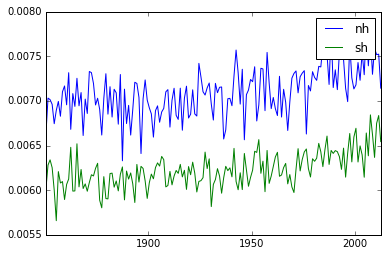

In [27]:
#iplt.plot(out_cubes[0], label='globe')
iplt.plot(out_cubes[1], label='nh')
iplt.plot(out_cubes[2], label='sh')
plt.legend()
plt.show()